# Data Classificaiton Project #

This project is to classify a dataset of grey-scale images to different labels with supervised classifiers. We first pre-process the data with Normalisation and Principal Component Analysis(PCA), then classify our data with K-Nearest-Neighbors (KNN) and Logistic Regression using One-Versus-One (OVO) and One-Versus-All (OVA) methods.

In [1]:
import h5py
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as pl
import time


import pandas as pd
import seaborn as sn

### Read files
Read the 4 input files: images_training.h5, labels_training.h5, images_testing.h5, labels_testing_2000.h5

In [2]:
# Read all the input files, which includes: 
# images_training.h5,
# labels_training.h5,
# images_testing.h5,
# labels_testing_2000.h5
# the output is the relavant data
def read_file():
    #folder = '~/Users/jingjingwu/Desktop/COMP5318/'
    with h5py.File('images_training.h5', 'r') as H:
        train_set_x_orig = np.copy(H['data'])
        train_set_x_orig = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1)
    with h5py.File('labels_training.h5', 'r') as H:
        train_set_y_orig = np.copy(H['label'])

    with h5py.File('images_testing.h5', 'r') as H:
        test_set_x_orig = np.copy(H['data'])[:2000]
        test_set_x_orig = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1)
    with h5py.File('labels_testing_2000.h5', 'r') as H:
        test_set_y_orig = np.copy(H['label'])
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig


train_set_x, train_set_y, test_set_x, test_set_y = read_file()
print(train_set_y)
print(test_set_y)

[0 2 6 ... 3 1 2]
[3 4 6 ... 2 9 6]


In [3]:
# When we want to do validation, take the first 2000 data as the validation data,
# and the other data as the training data

validation_train_x = train_set_x[:2000]
validation_train_y = train_set_y[:2000]
other_train_x = train_set_x[2000:]
other_train_y = train_set_y[2000:]

#print(validation_train_x)
#print(validation_train_y)

### Normalisation

In [4]:
# Perform normalisation before inputing the data into the model

def normalisation(data, minimum, maximum):
    return (data - minimum) / (maximum - minimum)

# Get the minimum and maximnum value from the trainning data for the nomalisation
max_train = np.max(train_set_x)
min_train = np.min(train_set_x)

# Normailize the data
train_set_x_norm = normalisation(train_set_x, min_train, max_train)
test_set_x_norm = normalisation(test_set_x, min_train, max_train)

# When we do not need to validation, we use all the input data as training data
train_set_x = train_set_x_norm[:30000]
train_set_y = train_set_y[:30000]
test_set_x=test_set_x_norm

# print(train_set_x.shape)
# print(train_set_y.shape)
# print(test_set_x.shape)
# print(test_set_y.shape)

### Singular Value Decomposition ###
Decrease the dimension of the data, and extract the features from the data.

In [74]:
# Perform SVD to decrease the dimension of the data, do the feature selection
def svd_reconstruction(x):
    n_components = 200
    U, s, Vt = np.linalg.svd(x, full_matrices=False)
    S = np.diag(s)
    x_reconstructed = U[0:U.shape[0], 0:n_components].dot(S[0:n_components, 0:n_components]).dot(Vt[0:n_components, 0:Vt.shape[1]])
    SSE = np.sum((x - x_reconstructed) ** 2)
    print(x.shape[1], ' ', x.shape[0])
    comp_ratio = (x.shape[1] * n_components + n_components + x.shape[0] * n_components) / (x.shape[1] * x.shape[0])
    print('If we choose {} dominant singular value/s;\n SSE = {} and\n compresion ratio = {}\n\n'\
      .format(n_components, SSE, np.round(comp_ratio,10)))
    pl.figure(figsize=(15, 10))
    pl.subplot(111)
    pl.plot(np.arange(len(s)), s)
    pl.grid()
    pl.title('Singular values distribution')
    pl.xlabel('n')
    pl.show()

    return x_reconstructed

# train_set_x = svd_reconstruction(train_set_x)
# test_set_x=svd_reconstruction(test_set_x)

### Methods for training and optimisation

In [5]:
# We use the Sigmoid as the active function
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

# We use Cross Entropy as the loss function to evaluate the model
def loss(theta, x, y):
    l = x.shape[1]
    z = np.dot(x, theta.T)
    exp_z = sigmoid(z)
    loss_func =  np.sum(np.multiply(y, np.log(exp_z)) + np.multiply(1 - y, np.log(1 - exp_z))) / (-l)
    the_lambda = 0.001 # the_lambda is the regularizaton parameter 
#     reg=(1/(2*len(x)))*np.sum(np.power(theta,2))
#     new_loss=loss_func/len(x)+reg
    
    new_loss = loss_func + 1 / 2 * the_lambda * theta.dot(theta.T)
    
    # If the loss is 0
    if np.isnan(new_loss):
        return np.inf
    return new_loss

# The math function for gradient descent used in the loss function
def gradient_descent(theta,x,y):
    theta = np.matrix(theta)
    x = np.matrix(x)
    y = np.matrix(y)
    z = np.dot(x, theta.T)
    exp_z = sigmoid(z)
    loss_out = np.sum(np.multiply((exp_z - y), x), axis=0)+1/2*theta
#     loss_out = np.sum(np.multiply((exp_z - y), x), axis=0)/len(x)+(1/len(x)*theta)
    return loss_out

# This method includes two optimization methods, which is gDescent and momentum which is writen manually 
def gDescent( x, y, method, reg=False):
        m , n = x.shape
  
        learning_rate = 0.1
        counter = 0
        cur_cost = np.inf
        momentum=0.1
        gradient=0
        p = 1e-3
        reg_value=0.01
        w=np.zeros(n)
        cur_cost_list=[]
        
        n_iterations = 4000
        while(counter < n_iterations):
            h_x = np.dot(x, w.T)
            y_pred = sigmoid(h_x)
            y_pred = y_pred.reshape(m,1)
            w_grad = x.T.dot(y_pred - y) / x.shape[0]
            w_grad = w_grad.reshape(1,n)

            # if regularisation is requested
            if reg:
                w_grad = w_grad + reg*w      
            
            # If momentum is required
            if method=="Momentem":
                gradient = momentum * gradient + learning_rate * w_grad
                gradient = gradient.reshape(n,)
                w = w - gradient.T
          
            # use for baseline
            w = w - learning_rate * w_grad
            cur_cost = np.sum(np.multiply(y, np.log(y_pred)) + np.multiply(1 - y, np.log(1 - y_pred))) / (-x.shape[1])
            
            # If regularisation, we add one more item to the cur_cost
            if reg:
                cur_cost = cur_cost+reg_value*1 / 2 * w.dot(w.T) / (-x.shape[1])
           
            counter += 1
            
            # Collect the cost each 200 iteration
            if counter%200==0:
                 cur_cost_list.append(cur_cost)
                
            if cur_cost <= p:
                break
       
        return w,counter, cur_cost_list



### Methods for OVA model

In [76]:
# The methods to train the OVA model
def train(x, y, num_labels):
    start=time.time()
    num_of_data = x.shape[0]
    num_of_param = x.shape[1]

    # build k classifiers, all_theta is a (10, 785) matrix
    all_theta = np.random.random((num_labels, num_of_param + 1))

    # insert x0 as the first column
    x = np.insert(x, 0, values=np.ones(num_of_data), axis=1)

    # classify by y, separately train 10 classifiers
    for i in range(0, num_labels):
        theta = np.zeros(num_of_param + 1)
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i = y_i.reshape(num_of_data, 1)

        # train 100 data each time, use mini_batch gradient descent here
        size = 100
        for j in range(size, num_of_data + 1, size):
            y_j = y_i[j - size: j]
            x_j = x[j - size: j]
            # use the TNC optimisation and use the built in function "minimise" to calculate the weight with samll loss
            theta_min = minimize(fun=loss, x0=theta, args=(x_j, y_j), method='TNC', jac=gradient_descent)
            #gD=gDescent( x_j, y_j)
            #theta=gD[0]
            theta = theta_min.x
        #all_theta[i, :] = gD[0]
        #add all wight calculate from binary classification to all_theta
        all_theta[i, :] = theta_min.x
    final=time.time()
    total_time=final-start
    print("total_time",round(total_time,3))
    return all_theta

# all_theta = train(train_set_x, train_set_y, 10)
# print(all_theta)

In [6]:
#predict the test_x to get the prdict_test_y 
#input: x: all the test data,all_theta:the weight for the OVA model
#return thr predicate result
def predict(x, all_theta):
    num_of_data = x.shape[0]
    x = np.insert(x, 0, values=np.ones(num_of_data), axis=1)
    x = np.matrix(x)
    all_theta = np.matrix(all_theta)

    # calculate the possibility of every class
    possibilities = sigmoid(x.dot(all_theta.T))

    # choose the highest one
    result = np.argmax(possibilities, axis=1)
    return result


# results = predict(test_set_x, all_theta)
# print(results)

In [7]:
#calculate the accuracy of the model
#input:results:the predicate results,test_set_y:the y value of test instance 
#return the accuracy value of the model using test data
def accuracy(results,test_set_y):
   
    correct_rate = [1 if y_hat == y else 0 for (y_hat, y) in zip(results, test_set_y)]
    accu = (sum(correct_rate) / test_set_y.shape[0])
   
    return accu


# accuracy(results,test_set_y)

In [8]:
import random
# this function choose out each two y label form the 10 y labels 
# input : y_1:the choosed first y label ,y_2 :the choosed second y label,x :x of the total input data, y:y of the total input data
# output: the selected x and y data
def _oneVsOne(y_1,y_2,x,y):
    
    y1_Id=np.where(y==y_1)[0]
    y2_Id=np.where(y==y_2)[0]
    y1_Id=np.concatenate((y1_Id,y2_Id))
   
    random.shuffle(y1_Id)
    new_x=x[y1_Id] 
    y_conc=y[y1_Id]
    
    print("y_conc",y_conc)
    new_y=_changed_l(y_conc,y_1,y_2)
    return new_x,new_y
# signed the choosed data to the new label of 1 or 0  
#input:y_new:all the choosed y data,y_1：the first choosed y label,y_2 :the second choosed y label
# output:the resigned y data
def _changed_l(y_new,y_1,y_2):
    y_new=np.array([1 if y_new == y_1 else 0 for y_new in y_new])
    return y_new


#the train OVO model function
#input : x:the training_set_x,y:the training_set_y,method : the optimisation method choosed
#output: the oow:the weight of this model,list_y_pair:the paired diffrent y choosed from the 10 labels each time.
def train_one_vs_one(x,y,method):
    oow=[]
    list_y_pair=[]
    y_length= len(np.unique(y))
    
    xi,xj=x.shape
    #we need n times to 
    n=0.5*y_length*(y_length-1)
    oow = []
    x = np.insert(x, 0, values=np.ones(xi), axis=1)
    
    time1=time.time()
    for y_1 in np.arange(y_length):
        for y_2 in np.arange(y_1+1,y_length):
            
            s_ovo=time.time()
            new_x,new_y=_oneVsOne(y_1,y_2,x,y)
            e_ovo=time.time()
            time_=e_ovo-s_ovo
            print("time_ovo:",round(time_,3))
            
            new_x_i,new_x_j=new_x.shape
            new_y=new_y.reshape(new_x_i ,1)
            
            size=100
            num_of_data=len(new_x)
            start_m=time.time()
            #if the optimisationm method is TNC
            if method=="TNC":
                for j in range(size, num_of_data + 1, size):
                    x_j =new_x[j - size: j]
                    y_j =new_y[j - size: j]
                    w0=np.zeros(xj +1)
                    w_min=minimize(fun=loss, x0=w0, args=(x_j, y_j), method='TNC', jac=gradient_descent)
                 
                oow.append(w_min.x)
            #if the optimisation method is "Momentum"
            if method =="Momentum":
                w_min=0
                for j in range(size, num_of_data + 1, size):
                    x_j =new_x[j - size: j]
                    y_j =new_y[j - size: j]
               
                    w0=np.zeros(xj +1)
                    #the following two lines used for gDescent 
                    gD=gDescent( x_j, y_j,"Momentum",False)
                    w_min=gD[0]
                    cur_cost_list=gD[2]
                oow.append(w_min)
            #if the optimisation method is gDescent
            if method=="gDescent":
                w_min=0
                for j in range(size, num_of_data + 1, size):
                    x_j =new_x[j - size: j]
                    y_j =new_y[j - size: j]
               
                    w0=np.zeros(xj +1)
                    #the following two lines used for gDescent 
                    gD=gDescent( x_j, y_j,"gDescent")
                    w_min=gD[0]
               
                    cur_cost_list=gD[2]
                oow.append(w_min)
           
            end_m=time.time()
            time_=end_m-start_m
            print("time_minimise:",round(time_,3))
            list_y_pair.append((y_1,y_2))
    print("length_oow",oow)
    time2=time.time()
    total_time=time2-time1
    print("total_time",total_time)
    oow = np.array(oow).reshape(int(n), xj+1)
    print("time:",round(time_,3))
    return oow,list_y_pair
        

#print("train_set_y",train_set_y)
# all_w=train_one_vs_one(np.array(train_set_x), np.array(train_set_y),"gDescent")
# print("all_w",all_w)

In [80]:
# validation_w=train_one_vs_one(np.array(validation_train_x),np.array(validation_train_y),"TNC")
# #print(validation_w)
# other_w=train_one_vs_one(np.array(other_train_x),np.array(other_train_y),"TNC")



### Methods for OVO model

In [9]:
#the predicate for the OVO model
#the input:X is the teat_set_x,oow :the weifht of the model,control: the choosed pair classes from the 1o label 
#output:the predicate label from the OVO model
def ovo_predict( X,oow,control):
        i,j=X.shape
        X = np.insert(X, 0, values=np.ones(i), axis=1)
        z = np.dot(X, oow.T)
       
        print("z.shape",z.shape)
        exp_z = sigmoid(z)
        print(exp_z)
        print("exp_z",exp_z.shape)
       
        # control=train_one_vs_one(x,y)[1]
        ind_list=[]
        for m in range(len(exp_z)):
            board = np.zeros(10)   
            for n in   range(len(exp_z[m])):
                
                if  exp_z[m][n] >= 0.5:
                    v_id = control[n][0]
                  
                    board[v_id] +=1
                else:
                    v_id = control[n][1]
                   
                    board[v_id] +=1
           # print(board)
            ind=np.argmax(board)
            ind_list.append(ind)
        
        return ind_list
    
# allw=all_w[0]

# control=all_w[1]
# print("control.shape",len(control))
# print("control",control)
# results = ovo_predict(test_set_x, allw,control)
# print(results)
# print(np.array(results).shape)

# accuracy(results,test_set_y)

### Methods for knn model

In [10]:
# knn model to claasify the data 
# Input: x:test_x, x_q:train_set_x, y:train_set_y, K:the nearest k instance
def knn(x,x_q,y,K):
    classes = np.zeros(10)
    
    distance = ((x - x_q)**2).sum(axis=1)
    arg_sorted = np.argsort(distance)
    
    for i in range(K):
        if y[arg_sorted[i]] in range(10):
            classes[y[arg_sorted[i]]] +=1
        else:
            print('Error - Invalid class')
        #calculate probability for each class 
        prob = classes/K
    #choose the class that has the greatest probability
    final = np.argmax(prob)
    return final




### Main Function ###
This is the main function, we can choose the model name and optimisation method.<br>
Input: train_set_x, train_set_y, test_set_x, test_set_y (preprocessed)<br>
Model: OVO, OVA, KNN <br>
Optimisation Methos: Momentum, TNS, gDescent <br>
Output: The predicated result.<br>

In [12]:
# This is the main function, to choose the model name and optimisation method
# Input : train_set_x,train_set_y,test_set_x,test_set_y
# Model method :"OVO","OVA"and "KNN" 
# Optimisation method :"Momentum","TNC","gDescent"
# Return : the predicated result of the model and optimisation method chosen
def mnist_predicate(train_set_x,train_set_y,test_set_x,test_set_y,model_name,optimisation_name):
    # If the chosen model is OVA
    if model_name=="OVA":
        all_theta = train(train_set_x, train_set_y, 10)
        results = predict(test_set_x, all_theta)
        # Calculate the accuracy when using this model
        correct_rate = [1 if y_hat == y else 0 for (y_hat, y) in zip(results, test_set_y)]
        accuracy = (sum(correct_rate) / test_set_y.shape[0])
        print("accuracy",accuracy)
        
       
        results1=results.reshape(2000,)
        results=np.array(results1)[0]
        #print(results)
        return results
    
    # If the chosen model is OVO    
    if model_name=="OVO":
        if optimisation_name=="TNC":
            all_w=train_one_vs_one(np.array(train_set_x), np.array(train_set_y),"TNC")
        if optimisation_name=="Momentum":
            all_w=train_one_vs_one(np.array(train_set_x), np.array(train_set_y),"Momentum")
        if optimisation_name=="gDescent":
            all_w=train_one_vs_one(np.array(train_set_x), np.array(train_set_y),"gDescent")
        allw=all_w[0]
        control=all_w[1]
        results = ovo_predict(test_set_x, allw,control)
        # Calculate the accuracy when using this model
        correct_rate = [1 if y_hat == y else 0 for (y_hat, y) in zip(results, test_set_y)]
        accuracy = (sum(correct_rate) / test_set_y.shape[0])
        print("accuracy",accuracy)
        return results   
       
    # If the  chosen model is KNN         
    if model_name=="KNN":
        results = []
        K = 3
        time_knn=time.time()
        for x in test_set_x:
            pre = knn(x, train_set_x,train_set_y,K)
            results.append(pre)
        time_knn_=time.time()
        print("total_time_knn",time_knn_-time_knn)
        
        c = 0
        for i in range(len(results)):
            if results[i] == test_set_y[i]:
                c+=1
        # Calculate the accuracy when using this model
        accuracy = c/len(results)
        print('Accuracy = ', accuracy * 100, '%')
        return results

        

### See the  results of our model. ###
The accuracy and training time is shown.

In [13]:
# Here we can see the time used for each binary classification. 
# The total time used and the accuracy at the end
results = mnist_predicate(train_set_x,train_set_y,test_set_x,test_set_y,"KNN"," ")

total_time_knn 389.97554898262024
Accuracy =  84.15 %


In [20]:
# Print the first 200 results
print(results[:200])

[3, 4, 4, 1, 0, 2, 4, 5, 7, 6, 7, 5, 0, 0, 7, 0, 7, 0, 7, 8, 9, 2, 7, 2, 0, 4, 0, 2, 7, 2, 7, 4, 7, 1, 9, 2, 2, 2, 5, 3, 5, 8, 0, 4, 9, 0, 0, 3, 9, 1, 2, 6, 6, 0, 2, 7, 4, 4, 5, 8, 9, 8, 6, 1, 6, 2, 1, 0, 1, 5, 3, 6, 7, 8, 8, 5, 4, 2, 3, 0, 8, 6, 4, 7, 5, 8, 8, 7, 7, 3, 6, 6, 2, 1, 4, 5, 4, 6, 7, 3, 3, 7, 9, 2, 2, 6, 1, 3, 0, 2, 4, 0, 4, 1, 0, 5, 7, 9, 4, 6, 6, 9, 4, 6, 4, 6, 0, 4, 3, 6, 2, 9, 0, 5, 3, 4, 5, 1, 2, 7, 5, 8, 3, 4, 1, 9, 4, 0, 8, 7, 6, 1, 9, 8, 6, 1, 3, 9, 0, 8, 7, 7, 3, 6, 8, 5, 9, 8, 4, 3, 0, 4, 7, 8, 7, 0, 4, 3, 2, 6, 7, 7, 1, 2, 2, 0, 0, 0, 6, 6, 3, 4, 6, 3, 6, 8, 5, 4, 5, 7]


### Plot the Confusion Matrix ###
Visualize the result to get a clearer view of the accuracy.

In [15]:
#draw the confusion matrix 
#input: y:real test y value, y_pred:y predicted value using model

def confusionMatrix(y, y_pred, show_all = True):
    y_pred=np.array(y_pred)
    y_actu = pd.Series(y, name = 'Actual')
    y_pred = pd.Series(y_pred, name = 'Predicted')
    #print( y_actu,y_pred)
    return pd.crosstab(y_actu, y_pred, margins=show_all)

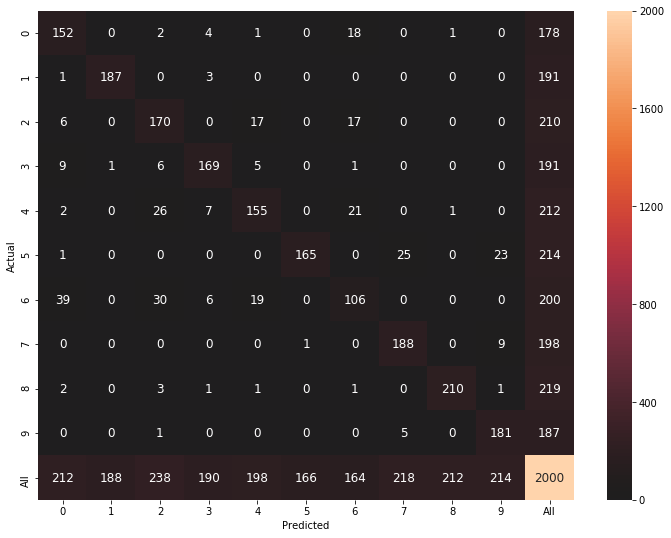

pc_list
 [[0.854 0.979 0.81  0.885 0.731 0.771 0.53  0.949 0.959 0.968]] 
rc_list
 [[0.717 0.995 0.714 0.889 0.783 0.994 0.646 0.862 0.991 0.846]] 
f1_list
 [[0.77952642 0.98693516 0.75897638 0.88699549 0.756107   0.86841246
  0.58227891 0.90341027 0.97473744 0.90289746]] 
prec_avg
 0.84 
rec_avg
 0.84 
f1_avg
 0.84 
res_df
               0     1     2     3     4     5     6     7     8     9
Precision  0.85  0.98  0.81  0.88  0.73  0.77  0.53  0.95  0.96  0.97
Recall     0.72  1.00  0.71  0.89  0.78  0.99  0.65  0.86  0.99  0.85
F1-score   0.78  0.99  0.76  0.89  0.76  0.87  0.58  0.90  0.97  0.90


In [16]:
# the following code is used to get the metrics of a specific model
cm=confusionMatrix(test_set_y, results, show_all = True)
#draw the confusion matrix
pl.figure(figsize = (12,9))
sn.heatmap(cm, annot=True, center = 20, fmt = 'd', annot_kws={"size": 12})
pl.show()
    
pc_list=[]
rc_list=[]
for value in cm.columns[:-1]:
    
        TP = cm[value][value]
        TP_and_FP  =cm["All"][value]
        #print(TP_and_FP )
        TP_and_FN = cm[value][10]
        #print(TP_and_FN )
        #calculate precision and recall for each value
        cur_pre = round((TP/TP_and_FP), 3)
        cur_rec = round((TP/TP_and_FN), 3)
        pc_list.append(cur_pre)
        rc_list.append(cur_rec)

# Get the precision and recall list         
pc_list = np.array(pc_list).reshape(1, len(pc_list))
rc_list = np.array(rc_list).reshape(1, len(rc_list))
f1_list = (2*pc_list*rc_list) / (pc_list + rc_list)
res = np.concatenate((pc_list, rc_list, f1_list), axis = 0)

res_df = pd.DataFrame(res, index = ['Precision', 'Recall', 'F1-score']).round(2)
# Calculate the avarage precision and recall value 
prec_avg = round(np.mean(pc_list), 2)
rec_avg = round(np.mean(rc_list), 2)
f1_avg = round(np.mean(f1_list), 2)


print( "pc_list\n",pc_list, "\nrc_list\n",rc_list, "\nf1_list\n",f1_list, "\nprec_avg\n",prec_avg, "\nrec_avg\n",rec_avg, "\nf1_avg\n",f1_avg, "\nres_df\n",res_df)   
        
        